<h1>Brain Tumor Detection via CNN ML Networks</h1>

Install libraries because they delete on AWS Sagemaker for some reason

In [20]:
!pip install seaborn
!pip install pyyaml h5py

Add and import neccesary libraries

In [33]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Loading the datasets (they are already split into Training and Testing datasets). The dataset is cited below but was downloaded off of Kaggle.com

In [23]:
# Set the path to the dataset
# Define the training and testing directories
train_dir = "/home/sagemaker-user/BrainTumorDetectionML/Data/Training"
test_dir = "/home/sagemaker-user/BrainTumorDetectionML/Data/Testing"

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

In [24]:
tf.config.list_physical_devices('GPU')

[]

<h3>Data Preprocessing</h3>

In [25]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * 
                                    count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)


<h2>Data Visualization with Bar Graph</h2>

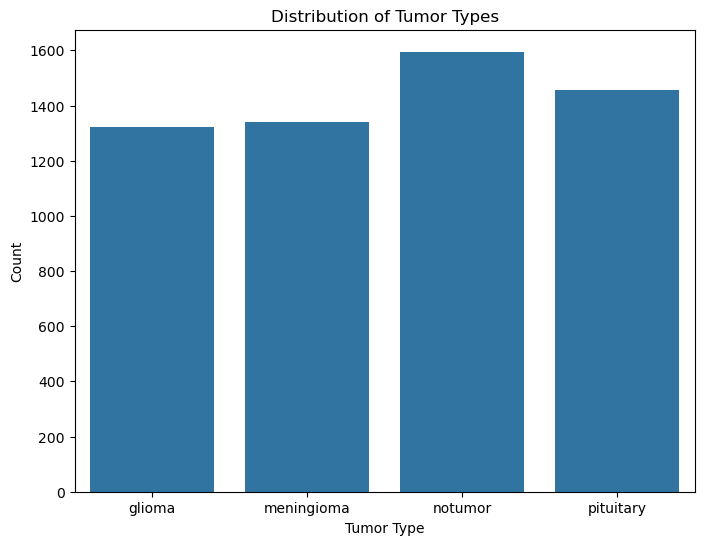

In [26]:
# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

<h2>Actual Example Images of each type of Tumor</h2>

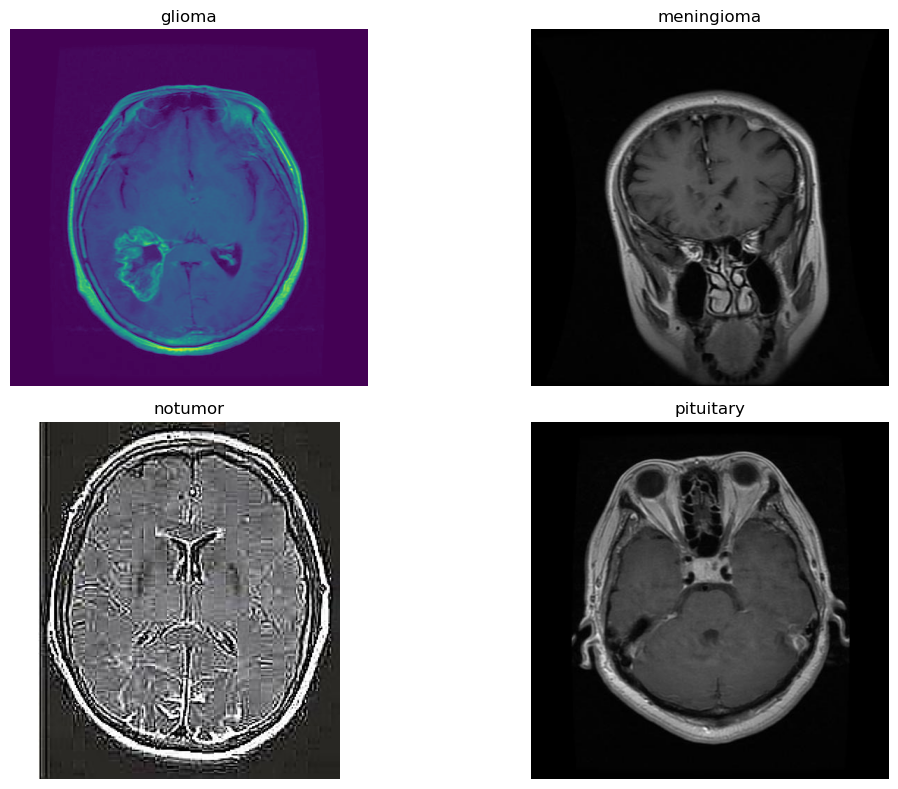

In [27]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

<h3>Image Preprocessing</h3>

Sets up size of the images as well as the total batch size for each epoch.

In [28]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

<h2>Data Augmentation/Preprocessing Continued</h2>

In [29]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [30]:
# Define the model architecture

with tf.device('/CPU:0'):
    model = keras.Sequential()
    model.add(keras.Input(shape=(image_size[0], image_size[1], 3, )))
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(len(categories), activation="softmax"))
    
    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 70s 389ms/step - loss: 0.9834 - accuracy: 0.5738 - val_loss: 1.1852 - val_accuracy: 0.5570
Epoch 2/50
178/178 [==============================] - 65s 364ms/step - loss: 0.7423 - accuracy: 0.7079 - val_loss: 0.8236 - val_accuracy: 0.6781
Epoch 3/50
178/178 [==============================] - 64s 361ms/step - loss: 0.6603 - accuracy: 0.7437 - val_loss: 1.2133 - val_accuracy: 0.5766
Epoch 4/50
178/178 [==============================] - 64s 359ms/step - loss: 0.6022 - accuracy: 0.7609 - val_loss: 1.1520 - val_accuracy: 0.5938
Epoch 5/50
178/178 [==============================] - 65s 362ms/step - loss: 0.5443 - accuracy: 0.7868 - val_loss: 1.1546 - val_accuracy: 0.5789
Epoch 6/50
178/178 [==============================] - 65s 363ms/step - loss: 0.5036 - accuracy: 0.8060 - val_loss: 0.6403 - val_accuracy: 0.7711
Epoch 7/50
178/178 [==============================] - 65s 363ms/step - loss: 0.4609 - accuracy: 0.8231 - val_loss: 0.7512 - val_ac

Save Model

In [35]:
model.save('tumorML.keras')

<h2>Precision & Accuracy Measurements</h2>

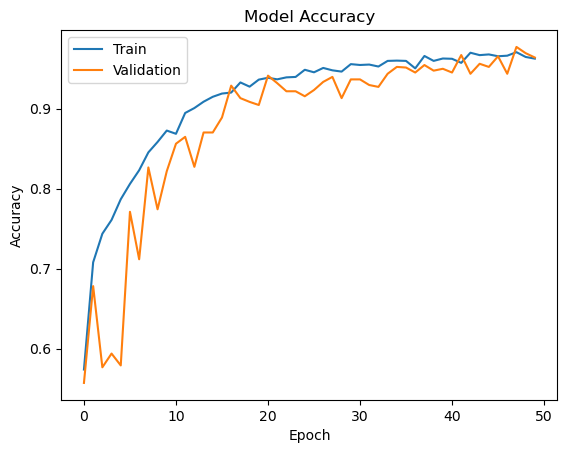

In [36]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

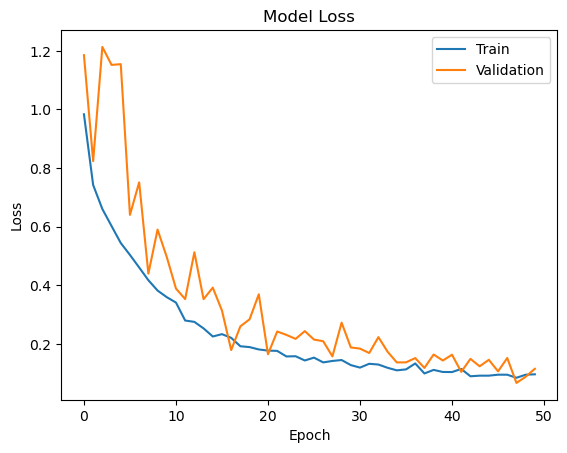

In [37]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 4s 92ms/step - loss: 0.1152 - accuracy: 0.9641
Test Loss: 0.1151932030916214
Test Accuracy: 0.964062511920929


41/41 [==============================] - 4s 93ms/step


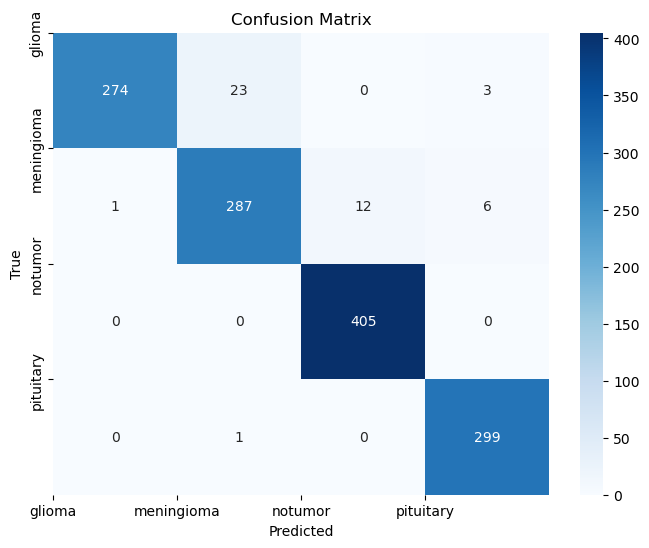

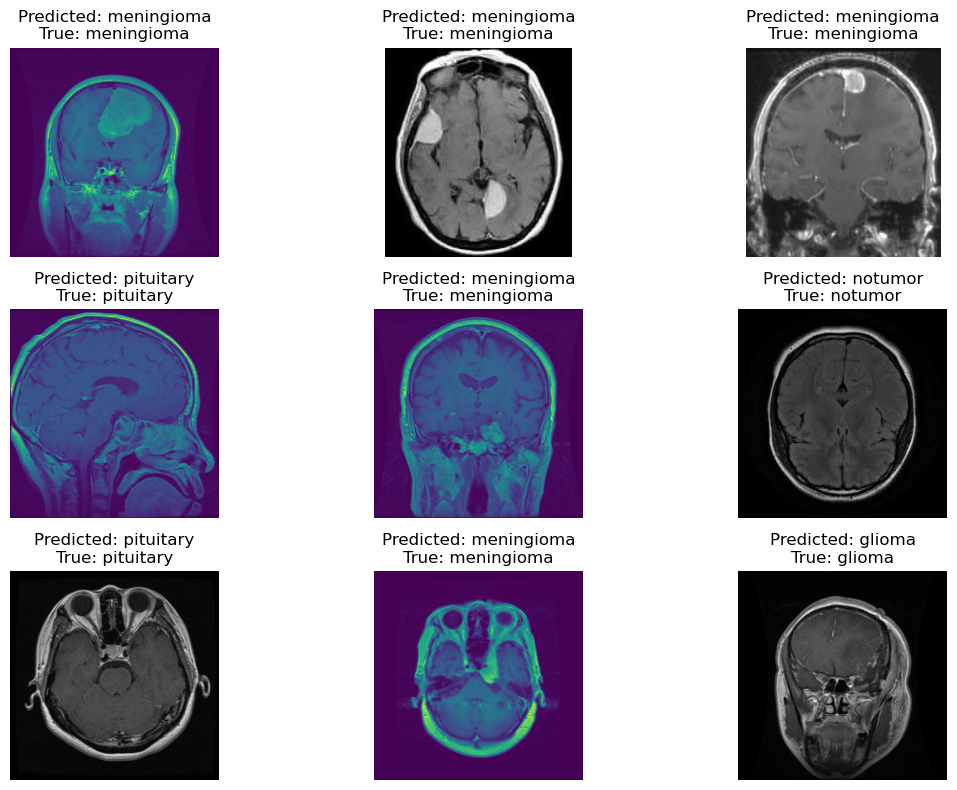

In [39]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9963636363636363
Recall: 0.9133333333333333
F1-Score: 0.9530434782608695

Class: meningioma
Precision: 0.9228295819935691
Recall: 0.9379084967320261
F1-Score: 0.9303079416531604

Class: notumor
Precision: 0.9712230215827338
Recall: 1.0
F1-Score: 0.9854014598540146

Class: pituitary
Precision: 0.9707792207792207
Recall: 0.9966666666666667
F1-Score: 0.9835526315789473



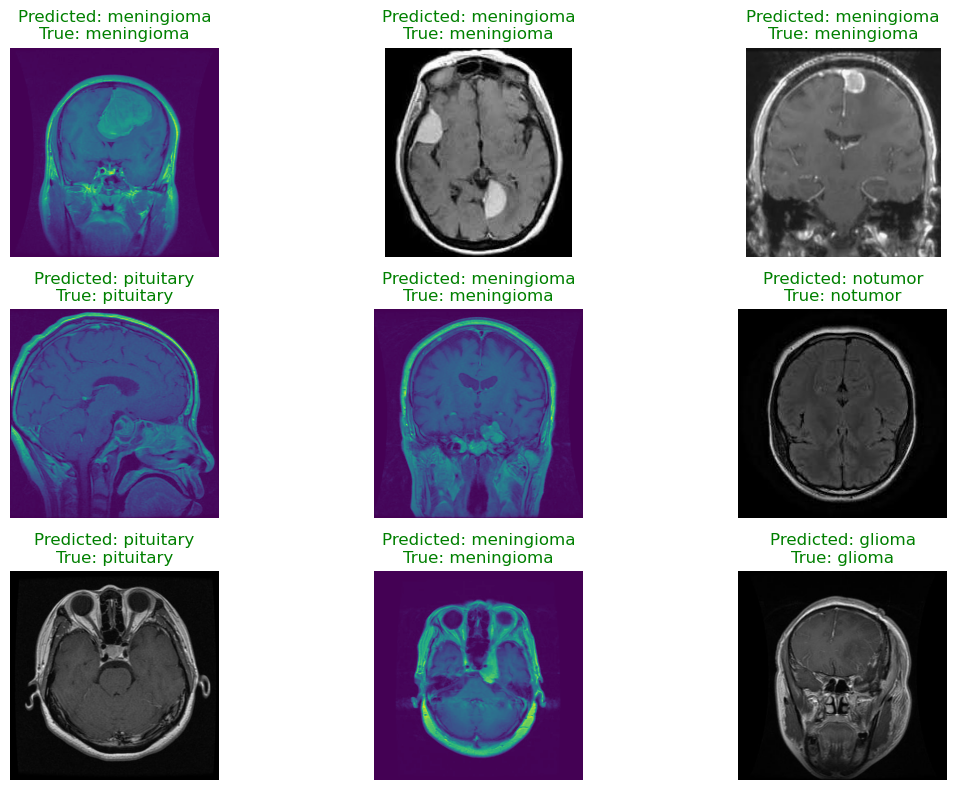

In [40]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [43]:
model.save("tumorML.h5")
model.save("tumorML.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
